In [2]:
import numpy as np
import time
import os
import multiprocessing as mp
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import palettable as pal

sns.set_context("talk",rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_style("whitegrid",{"grid.color": '.9', 'grid.linestyle': '--','axes.edgecolor': '.6', 'xtick.bottom': True,'ytick.left': True})


colorTable = {}
colorTable['k'] = [0,0,0]
colorTable['g'] = [27/255,158/255,119/255]
colorTable['o'] = [217/255,95/255,2/255]

from overlappingGenes import extract_params, initial_seq_no_stops, overlapped_sequence_generator_int, load_natural_energies

#### Functions

def load_data(family1,family2,verbose=False):
    """
    Load the data for a given pair of families.
    """
    dcaparams1 = root + family1 + '/' + family1 + '_params.dat'
    dcaparams2 = root + family2 + '/' + family2 + '_params.dat'

    Js_1, hs_1 = extract_params(dcaparams1)
    Js_2, hs_2 = extract_params(dcaparams2)

    # Length in amino acids, not including stop codons
    lenprot1 = len(hs_1)/21  # 21 is the number of amino acids incl blank
    lenprot2 = len(hs_2)/21  # 21 is the number of amino acids incl blank
   
    # Combining parameters
    DCA_params_1 = [Js_1, hs_1]
    DCA_params_2 = [Js_2, hs_2]

    return DCA_params_1, DCA_params_2, lenprot1, lenprot2

def process_single_overlap(params):
    """Process a single overlap combination and save results"""
    family1, family2, t1, t2, overlapLen = params
    
    # Create unique identifier for this run
    run_id = f"{family1}_{family2}_overlap{overlapLen}"
    
    # Load data
    DCA_params_1, DCA_params_2, lenprot1, lenprot2 = load_data(family1, family2)
        

    results = {}
    for rep in range(numreps):
        # Generate initial sequence
        initialCondition = initial_seq_no_stops(lenprot1, lenprot2, overlapLen,quiet=True)

        # Run simulation. Output is [seq, acceptedornot, energy_history_seq_1, energy_history_seq_2, finalenergies]
        output = overlapped_sequence_generator_int(DCA_params_1, DCA_params_2,
                                                initialCondition, 
                                                numberofiterations=numiter,
                                                T1=t1, T2=t2, quiet=True, whentosave=howoften)
        
        # Store only final results
        results[rep] = {
            'run_id': run_id,
            'initial_sequence': initialCondition,
            'final_sequence': output[0],
            'energy1': output[2],  # Energy time series for sequence 1
            'energy2': output[3],  # Energy time series for sequence 2
            'final_energies': output[4],  # Final energies for both sequences
            'parameters': {
                'family1': family1, 
                'family2': family2,
                'overlap': overlapLen,
                'T1': t1,
                'T2': t2,
                'num_iterations': numiter
            }
        }
    
    print(f"Completed {run_id}")

    return results

In [3]:
#### Parameters

root = "./"

families = ['PF00004', 'PF00041']
family_temperatures = [0.8,0.93] # Temperatures for the two families, picked by Kabir to match natural sequence statistics

numiter = 50000   # Number of iterations for the sequence generator
numreps = 5       # How many independent replicates
howoften = 0.005  # How often to save the energy during generation. Multiply by 100 to get percentage of iterations

#### Overlap away

family1, family2 = families[0],families[1]
t1, t2 = family_temperatures[0], family_temperatures[1]

DCA_params_1, DCA_params_2, lenprot1, lenprot2 = load_data(family1, family2)

overlapLength = 20
overlappingResults = process_single_overlap([family1, family2, t1, t2, overlapLength])

Completed PF00004_PF00041_overlap20


In [4]:
# Read in the energies of natural sequences
naturalenergies1_file = "./PF00004/PF00004_naturalenergies.txt"
naturalenergies2_file = "./PF00041/PF00041_naturalenergies.txt"

naturalenergies1 = load_natural_energies(naturalenergies1_file)
naturalenergies2 = load_natural_energies(naturalenergies2_file)
mean_1 = np.mean(naturalenergies1)
mean_2 = np.mean(naturalenergies2)
sd_1 = np.std(naturalenergies1)
sd_2 = np.std(naturalenergies2)

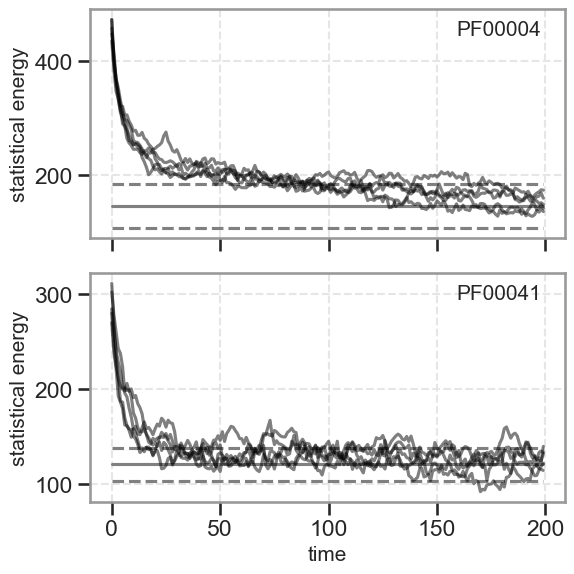

In [5]:
#### Plot results

fig, axs = plt.subplots(2,1, sharex = True)
fig.set_size_inches(6,6)

xv = np.arange(len(overlappingResults[0]["energy1"]))
energy1 = overlappingResults[0]["energy1"] 
energy2 = overlappingResults[0]["energy2"]

xv = np.arange(len(overlappingResults[0]["energy1"]))
axs[0].plot(xv, np.ones_like(energy1)*mean_1, "-", color = "gray")
axs[0].plot(xv, np.ones_like(energy1)*(mean_1 + sd_1), "--", color = "gray")
axs[0].plot(xv, np.ones_like(energy1)*(mean_1 - sd_1), "--", color = "gray")
axs[1].plot(xv, np.ones_like(energy1)*mean_2, "-", color = "gray")
axs[1].plot(xv, np.ones_like(energy1)*(mean_2 + sd_2), "--", color = "gray")
axs[1].plot(xv, np.ones_like(energy1)*(mean_2 - sd_2), "--", color = "gray")

for rep in range(numreps):
    energy1 = overlappingResults[rep]["energy1"]
    energy2 = overlappingResults[rep]["energy2"]
    axs[0].plot(energy1, "k", alpha = 0.5)
    axs[1].plot(energy2, "k", alpha = 0.5)

axs[0].text(0.95, 0.95, f'{family1}', horizontalalignment='right',verticalalignment='top', transform=axs[0].transAxes)
axs[1].text(0.95, 0.95, f'{family2}', horizontalalignment='right',verticalalignment='top', transform=axs[1].transAxes)

axs[-1].set_xlabel("time")
axs[0].set_ylabel("statistical energy")
axs[1].set_ylabel("statistical energy")

plt.tight_layout()


In [6]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Import all functions from your NEW optimized file ---
# This gives us all the helpers (translators, loaders)
# and the *OPTIMIZED* simulation function
from overlappingGenes import (
    extract_params, initial_seq_no_stops, load_natural_energies,
    calculate_Energy, calculate_energies, # Original O(L^2) functions
    seq_str_to_int_array, split_sequence_and_to_aa_int, 
    change_random_codon_int,
    int_array_to_seq_str,
    overlapped_sequence_generator_int # This is the OPTIMIZED O(L) version
)

def load_data(family1,family2,verbose=False, root="./"):
    """
    Load the data for a given pair of families.
    """
    dcaparams1 = root + family1 + '/' + family1 + '_params.dat'
    dcaparams2 = root + family2 + '/' + family2 + '_params.dat'

    Js_1, hs_1 = extract_params(dcaparams1)
    Js_2, hs_2 = extract_params(dcaparams2)

    # Length in amino acids, not including stop codons
    lenprot1 = len(hs_1)/21  # 21 is the number of amino acids incl blank
    lenprot2 = len(hs_2)/21  # 21 is the number of amino acids incl blank
   
    # Combining parameters
    DCA_params_1 = [Js_1, hs_1]
    DCA_params_2 = [Js_2, hs_2]

    return DCA_params_1, DCA_params_2, lenprot1, lenprot2
# --- 2. Manually define the ORIGINAL slow simulation function ---
# I've copied this from your original file upload and renamed it.
# It calls the same helpers, but calls calculate_energies (O(L^2)) inside the loop.
def overlapped_sequence_generator_int_ORIGINAL(DCA_params_1, DCA_params_2, initialsequence, T1=1, T2=1, numberofiterations=100000, quiet=False, whentosave=0.1):
    Jvec1, hvec1 = DCA_params_1
    Jvec2, hvec2 = DCA_params_2

    seq = seq_str_to_int_array(initialsequence)
    sequence_L = len(seq)
    len_seq_1_n = int(3*len(hvec1)/21 + 3)
    len_seq_2_n = int(3*len(hvec2)/21 + 3)

    accepted = 0.0
    prob_accepted = 0
    not_accepted = 0
    energy_history_seq_1 = []
    energy_history_seq_2 = []

    # O(L^2) calculation
    aa_seq_1, aa_seq_2 = split_sequence_and_to_aa_int(seq, len_seq_1_n, len_seq_2_n)
    E1, E2, E = calculate_energies(aa_seq_1, aa_seq_2, Jvec1, hvec1, Jvec2, hvec2)

    energy_history_seq_1.append(E1)
    energy_history_seq_2.append(E2)

    itera = 1
    nextmessage = 100*whentosave
    while itera < numberofiterations:
        if 100*(itera/numberofiterations) > nextmessage:
            nextmessage += 100*whentosave
            energy_history_seq_1.append(E1)
            energy_history_seq_2.append(E2)

        new_seq, new_pos, new_nuc = change_random_codon_int(sequence_L, seq)
        aa_seq_1_new, aa_seq_2_new = split_sequence_and_to_aa_int(new_seq, len_seq_1_n, len_seq_2_n)

        # Check for invalid stop codons
        stop_codon_error = False
        if aa_seq_1_new[-1] != "*" or aa_seq_2_new[-1] != "*":
            stop_codon_error = True
        else:
            for i in range(len(aa_seq_1_new) - 1):
                if aa_seq_1_new[i] == '*': stop_codon_error = True; break
            if not stop_codon_error:
                for i in range(len(aa_seq_2_new) - 1):
                    if aa_seq_2_new[i] == '*': stop_codon_error = True; break
        
        if stop_codon_error:
            not_accepted += 1
            itera += 1
            continue
            
        # --- THIS IS THE SLOW O(L^2) PART ---
        E1_new, E2_new, E_new = calculate_energies(aa_seq_1_new, aa_seq_2_new, Jvec1, hvec1, Jvec2, hvec2)
        delta_H_1 = E1_new - E1
        delta_H_2 = E2_new - E2
        # --- END SLOW PART ---
        
        delta_H = (delta_H_1/T1) + (delta_H_2/T2)

        if delta_H <= 0:
            seq = new_seq.copy()
            E1 = E1_new # E1 + delta_H_1
            E2 = E2_new # E2 + delta_H_2
            E = E1_new + E2_new # E + delta_H_1 + delta_H_2
            accepted += 1
        else:
            probability = np.exp(-delta_H)
            random_number = np.random.rand()
            if random_number < probability:
                seq = new_seq.copy()
                E1 = E1_new # E1 + delta_H_1
                E2 = E2_new # E2 + delta_H_2
                E = E1_new + E2_new # E + delta_H_1 + delta_H_2
                prob_accepted += 1
            else:
                not_accepted += 1

        itera += 1

    finalenergies = np.array([E1, E2])
    acceptedornot = [accepted, prob_accepted, not_accepted]

    return int_array_to_seq_str(seq), acceptedornot, np.array(energy_history_seq_1), np.array(energy_history_seq_2), finalenergies

# --- 3. Set up benchmark parameters ---
root = "./"
families = ['PF00004', 'PF00041']
family_temperatures = [0.8, 0.93]
family1, family2 = families[0], families[1]
t1, t2 = family_temperatures[0], family_temperatures[1]

# Parameters to test
overlap_lengths = [20,40, 60,80, 100]
iteration_counts = np.linspace(10000, 100000,10)
fixed_iters = 50000  # Use a smaller number for the overlap test
fixed_overlap = 60   # Use a mid-range overlap for the iteration test

# Store results
results = []

# --- 4. Load data ONCE ---
print("Loading DCA parameters...")
DCA_params_1, DCA_params_2, lenprot1, lenprot2 = load_data(family1, family2, root=root)
print(f"Prot1 Len: {lenprot1} AA, Prot2 Len: {lenprot2} AA")

# --- 5. Run Benchmark 1: Varying Overlap Length ---
print(f"\n--- Benchmarking: Varying Overlap (Iterations fixed at {fixed_iters}) ---")
for overlap in overlap_lengths:
    print(f"Testing overlap: {overlap}...")
    # Generate one initial sequence for this geometry
    initial_seq = initial_seq_no_stops(lenprot1, lenprot2, overlap, quiet=True)
    
    # Time Original
    start_time = time.time()
    overlapped_sequence_generator_int_ORIGINAL(
        DCA_params_1, DCA_params_2, initial_seq, 
        T1=t1, T2=t2, numberofiterations=fixed_iters, quiet=True
    )
    time_original = time.time() - start_time
    
    # Time Optimized
    start_time = time.time()
    overlapped_sequence_generator_int(  # This is the optimized one from import
        DCA_params_1, DCA_params_2, initial_seq, 
        T1=t1, T2=t2, numberofiterations=fixed_iters, quiet=True
    )
    time_optimized = time.time() - start_time
    
    results.append({
        "Test": "Varying Overlap",
        "Overlap": overlap,
        "Iterations": fixed_iters,
        "Time_Original (s)": time_original,
        "Time_Optimized (s)": time_optimized
    })

# --- 6. Run Benchmark 2: Varying Iterations ---
print(f"\n--- Benchmarking: Varying Iterations (Overlap fixed at {fixed_overlap}) ---")
# Generate one initial sequence for this geometry
initial_seq = initial_seq_no_stops(lenprot1, lenprot2, fixed_overlap, quiet=True)

for iters in iteration_counts:
    print(f"Testing iterations: {iters}...")
    
    # Time Original
    start_time = time.time()
    overlapped_sequence_generator_int_ORIGINAL(
        DCA_params_1, DCA_params_2, initial_seq, 
        T1=t1, T2=t2, numberofiterations=iters, quiet=True
    )
    time_original = time.time() - start_time
    
    # Time Optimized
    start_time = time.time()
    overlapped_sequence_generator_int(  # This is the optimized one from import
        DCA_params_1, DCA_params_2, initial_seq, 
        T1=t1, T2=t2, numberofiterations=iters, quiet=True
    )
    time_optimized = time.time() - start_time
    
    results.append({
        "Test": "Varying Iterations",
        "Overlap": fixed_overlap,
        "Iterations": iters,
        "Time_Original (s)": time_original,
        "Time_Optimized (s)": time_optimized
    })

# --- 7. Display Results ---
print("\n--- Benchmark Results ---")
df_results = pd.DataFrame(results)
print(df_results.to_markdown(index=False))

# Calculate and print speedup
df_results['Speedup (Optimized vs Original)'] = df_results['Time_Original (s)'] / df_results['Time_Optimized (s)']
print("\n--- Performance ---")
print(df_results[['Test', 'Overlap', 'Iterations', 'Speedup (Optimized vs Original)']].to_markdown(index=False))


# --- 8. Plot Results ---
print("\nPlotting results...")
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Benchmark: Original (O(L^2)) vs. Optimized (O(L))", fontsize=16)

# Plot 1: Varying Overlap
df_overlap = df_results[df_results['Test'] == 'Varying Overlap']
axs[0].plot(df_overlap['Overlap'], df_overlap['Time_Original (s)'], 'o-', label='Original (Slow)')
axs[0].plot(df_overlap['Overlap'], df_overlap['Time_Optimized (s)'], 'o-', label='Optimized (Fast)')
axs[0].set_xlabel("Overlap Length (nucleotides)")
axs[0].set_ylabel("Execution Time (s)")
axs[0].set_title(f"Time vs. Overlap (Iters = {fixed_iters})")
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.6)

# Plot 2: Varying Iterations
df_iters = df_results[df_results['Test'] == 'Varying Iterations']
axs[1].plot(df_iters['Iterations'], df_iters['Time_Original (s)'], 'o-', label='Original (Slow)')
axs[1].plot(df_iters['Iterations'], df_iters['Time_Optimized (s)'], 'o-', label='Optimized (Fast)')
axs[1].set_xlabel("Number of Iterations")
axs[1].set_ylabel("Execution Time (s)")
axs[1].set_title(f"Time vs. Iterations (Overlap = {fixed_overlap})")
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("benchmark_results.png")
print("Benchmark complete. Results saved to 'benchmark_results.png'")

ImportError: cannot import name 'split_sequence_and_to_aa_int' from 'overlappingGenes' (c:\Users\orson\OneDrive\Documents\OverlappingGenes\Project\overlappingGenes.py)